# 0.0 Imports

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt

from matplotlib import pyplot          as plt
from sklearn    import preprocessing   as pp
from sklearn    import model_selection as ms
from sklearn    import ensemble        as en
from sklearn    import neighbors       as nh
from sklearn    import linear_model    as lm

# 0.1 Loading Dataset

In [2]:
df_raw = pd.read_csv( 'data/insurance_data.csv' ).sort_values( by = 'id' )
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
143003,1,Male,44,28.0,26.0,0,40454.0,217,1,1,> 2 Years,Yes
286227,2,Male,76,3.0,26.0,0,33536.0,183,0,1,1-2 Year,No
143004,3,Male,47,28.0,26.0,0,38294.0,27,1,1,> 2 Years,Yes
190848,4,Male,21,11.0,152.0,1,28619.0,203,0,1,< 1 Year,No
238464,5,Female,29,41.0,152.0,1,27496.0,39,0,1,< 1 Year,No


# 1.0 Data Description

In [3]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [4]:
print( 'Numbers of rows {}'.format( df1.shape[0] ) )
print( 'Numbers of columns {}'.format( df1.shape[1] ) )

Numbers of rows 381109
Numbers of columns 12


## 1.2 Data Types

In [5]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.3 Check NA


In [6]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4 Data Descriptive

In [7]:
# separo em categoricos e numéricos
num_attributes = df1.select_dtypes( include = ['int64', 'float64']  )
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

In [8]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # calculado a media das colunas -- aplica em todas colunas
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T # calculando a mediana

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # calculando o std 
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # calculando o min
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # calculando o max
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min()  ) ).T # calcula o range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T # calcula o skew
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T # calcula o kurtosis

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['features','min','max','range','mean','median','std','skew','kurtosis'] 
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
7,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


# 2.0 Feature Engineering

In [9]:
df2 = df1.copy()
df2.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
143003,1,Male,44,28.0,26.0,0,40454.0,217,1,1,> 2 Years,Yes
286227,2,Male,76,3.0,26.0,0,33536.0,183,0,1,1-2 Year,No
143004,3,Male,47,28.0,26.0,0,38294.0,27,1,1,> 2 Years,Yes
190848,4,Male,21,11.0,152.0,1,28619.0,203,0,1,< 1 Year,No
238464,5,Female,29,41.0,152.0,1,27496.0,39,0,1,< 1 Year,No


In [10]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                                        if x == '1-2 Year' else 'below_1_year')
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x : 1 if x == 'Yes' else 0 )
df2.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
143003,1,Male,44,28.0,26.0,0,40454.0,217,1,1,over_2_years,1
286227,2,Male,76,3.0,26.0,0,33536.0,183,0,1,between_1_2_years,0
143004,3,Male,47,28.0,26.0,0,38294.0,27,1,1,over_2_years,1
190848,4,Male,21,11.0,152.0,1,28619.0,203,0,1,below_1_year,0
238464,5,Female,29,41.0,152.0,1,27496.0,39,0,1,below_1_year,0


# 3.0 Data Filtering

In [11]:
df3 = df2.copy()

# 4.0 EDA

In [12]:
df4 = df3.copy()

## 4.1 Univariate Analysis

<Axes: xlabel='response', ylabel='age'>

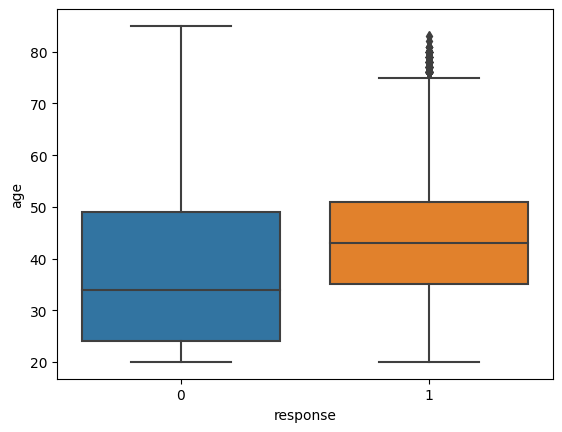

In [13]:
# age - vejo como está o comportamento baseado na idade
sns.boxplot( x = 'response', y = 'age', data = df4 )

<Axes: xlabel='age', ylabel='Count'>

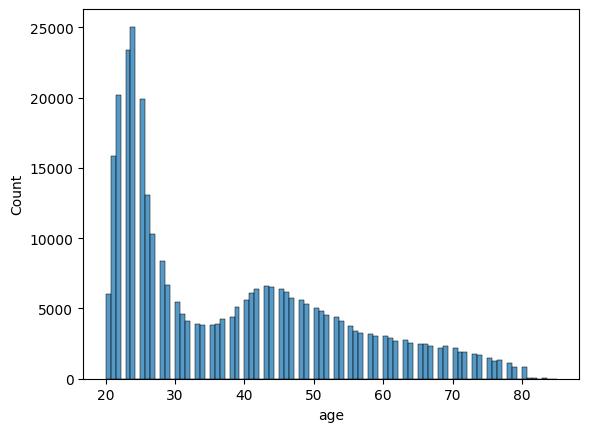

In [14]:
# pessoas que não tem interesse em comprar seguro
aux00 = df4.loc[ df4['response'] == 0 , 'age']
sns.histplot( aux00 )

<Axes: xlabel='age', ylabel='Count'>

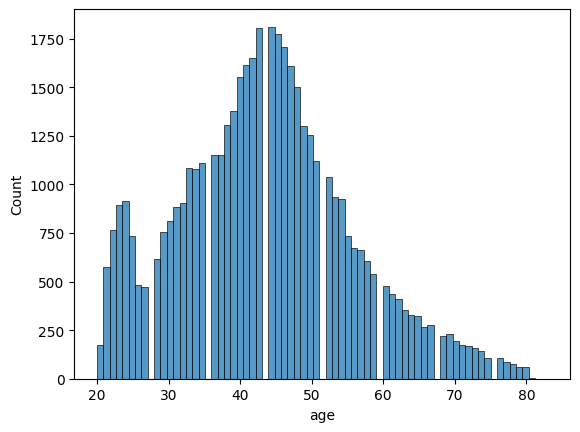

In [15]:
# pessoas que tem interesse em comprar seguro
aux00 = df4.loc[ df4['response'] == 1 , 'age']
sns.histplot( aux00 )

<Axes: xlabel='response', ylabel='annual_premium'>

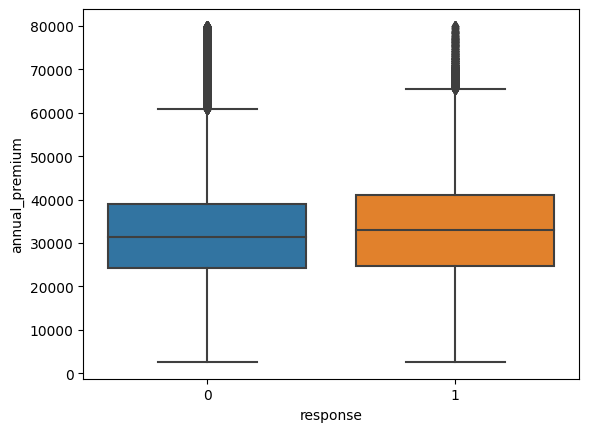

In [16]:
# annual_premium 
df_aux = df4.loc[ df4['annual_premium'] < 80000, : ]
sns.boxplot( x = 'response', y = 'annual_premium', data = df_aux  )

<Axes: xlabel='annual_premium', ylabel='Count'>

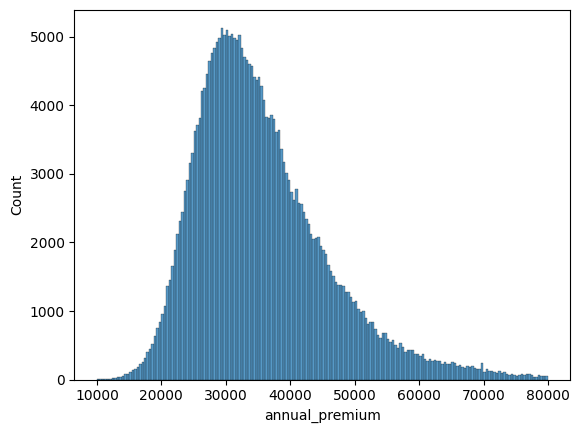

In [17]:
# verifico a distribuição
df_aux = df4.loc[ (df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000), : ]
aux00 = df_aux.loc[ df4['response'] == 0 , 'annual_premium']
sns.histplot( aux00 )

<Axes: xlabel='annual_premium', ylabel='Count'>

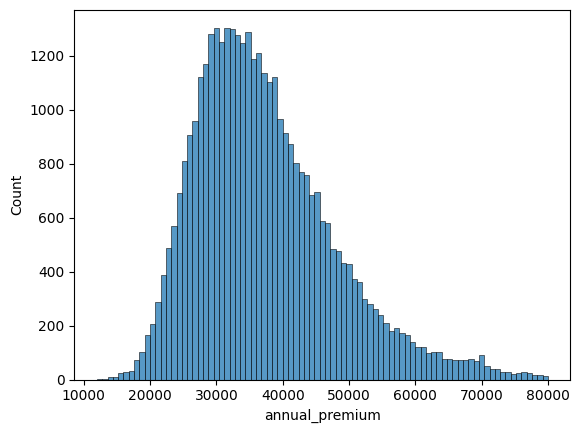

In [18]:
# verifico a distribuição
aux00 = df_aux.loc[ df4['response'] == 1 , 'annual_premium']
sns.histplot( aux00 )

<Axes: xlabel='response', ylabel='driving_license'>

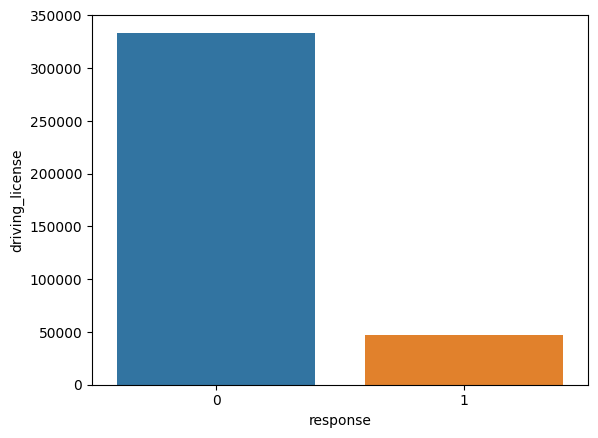

In [19]:
# driving_license
aux = df4[[ 'driving_license', 'response' ]].groupby( by = 'response' ).sum().reset_index()
sns.barplot( x = 'response', y = 'driving_license', data = aux )

In [20]:
# driving_license em %
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum() 
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='region_code', ylabel='id'>

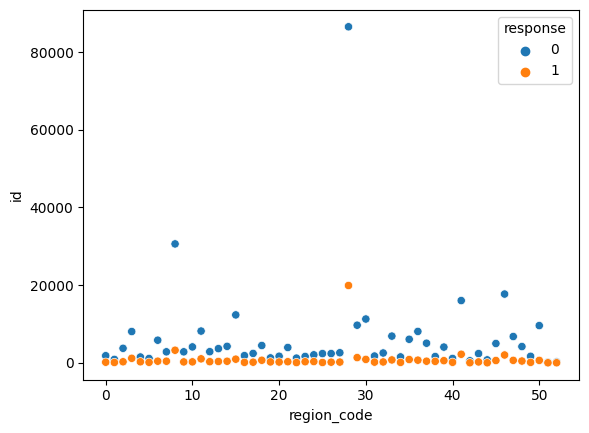

In [21]:
# region_code
aux0 = df4[['id','region_code','response']].groupby( by = ['region_code','response'] ).count().reset_index()
sns.scatterplot( x = 'region_code', y = 'id', hue = 'response', data = aux0 )

In [22]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis = 1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [23]:
# vehicle_age
df4[['vehicle_age','response']].value_counts( normalize = True ).reset_index().sort_values(by = 'vehicle_age')

,vehicle_age,response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


<Axes: xlabel='response', ylabel='policy_sales_channel'>

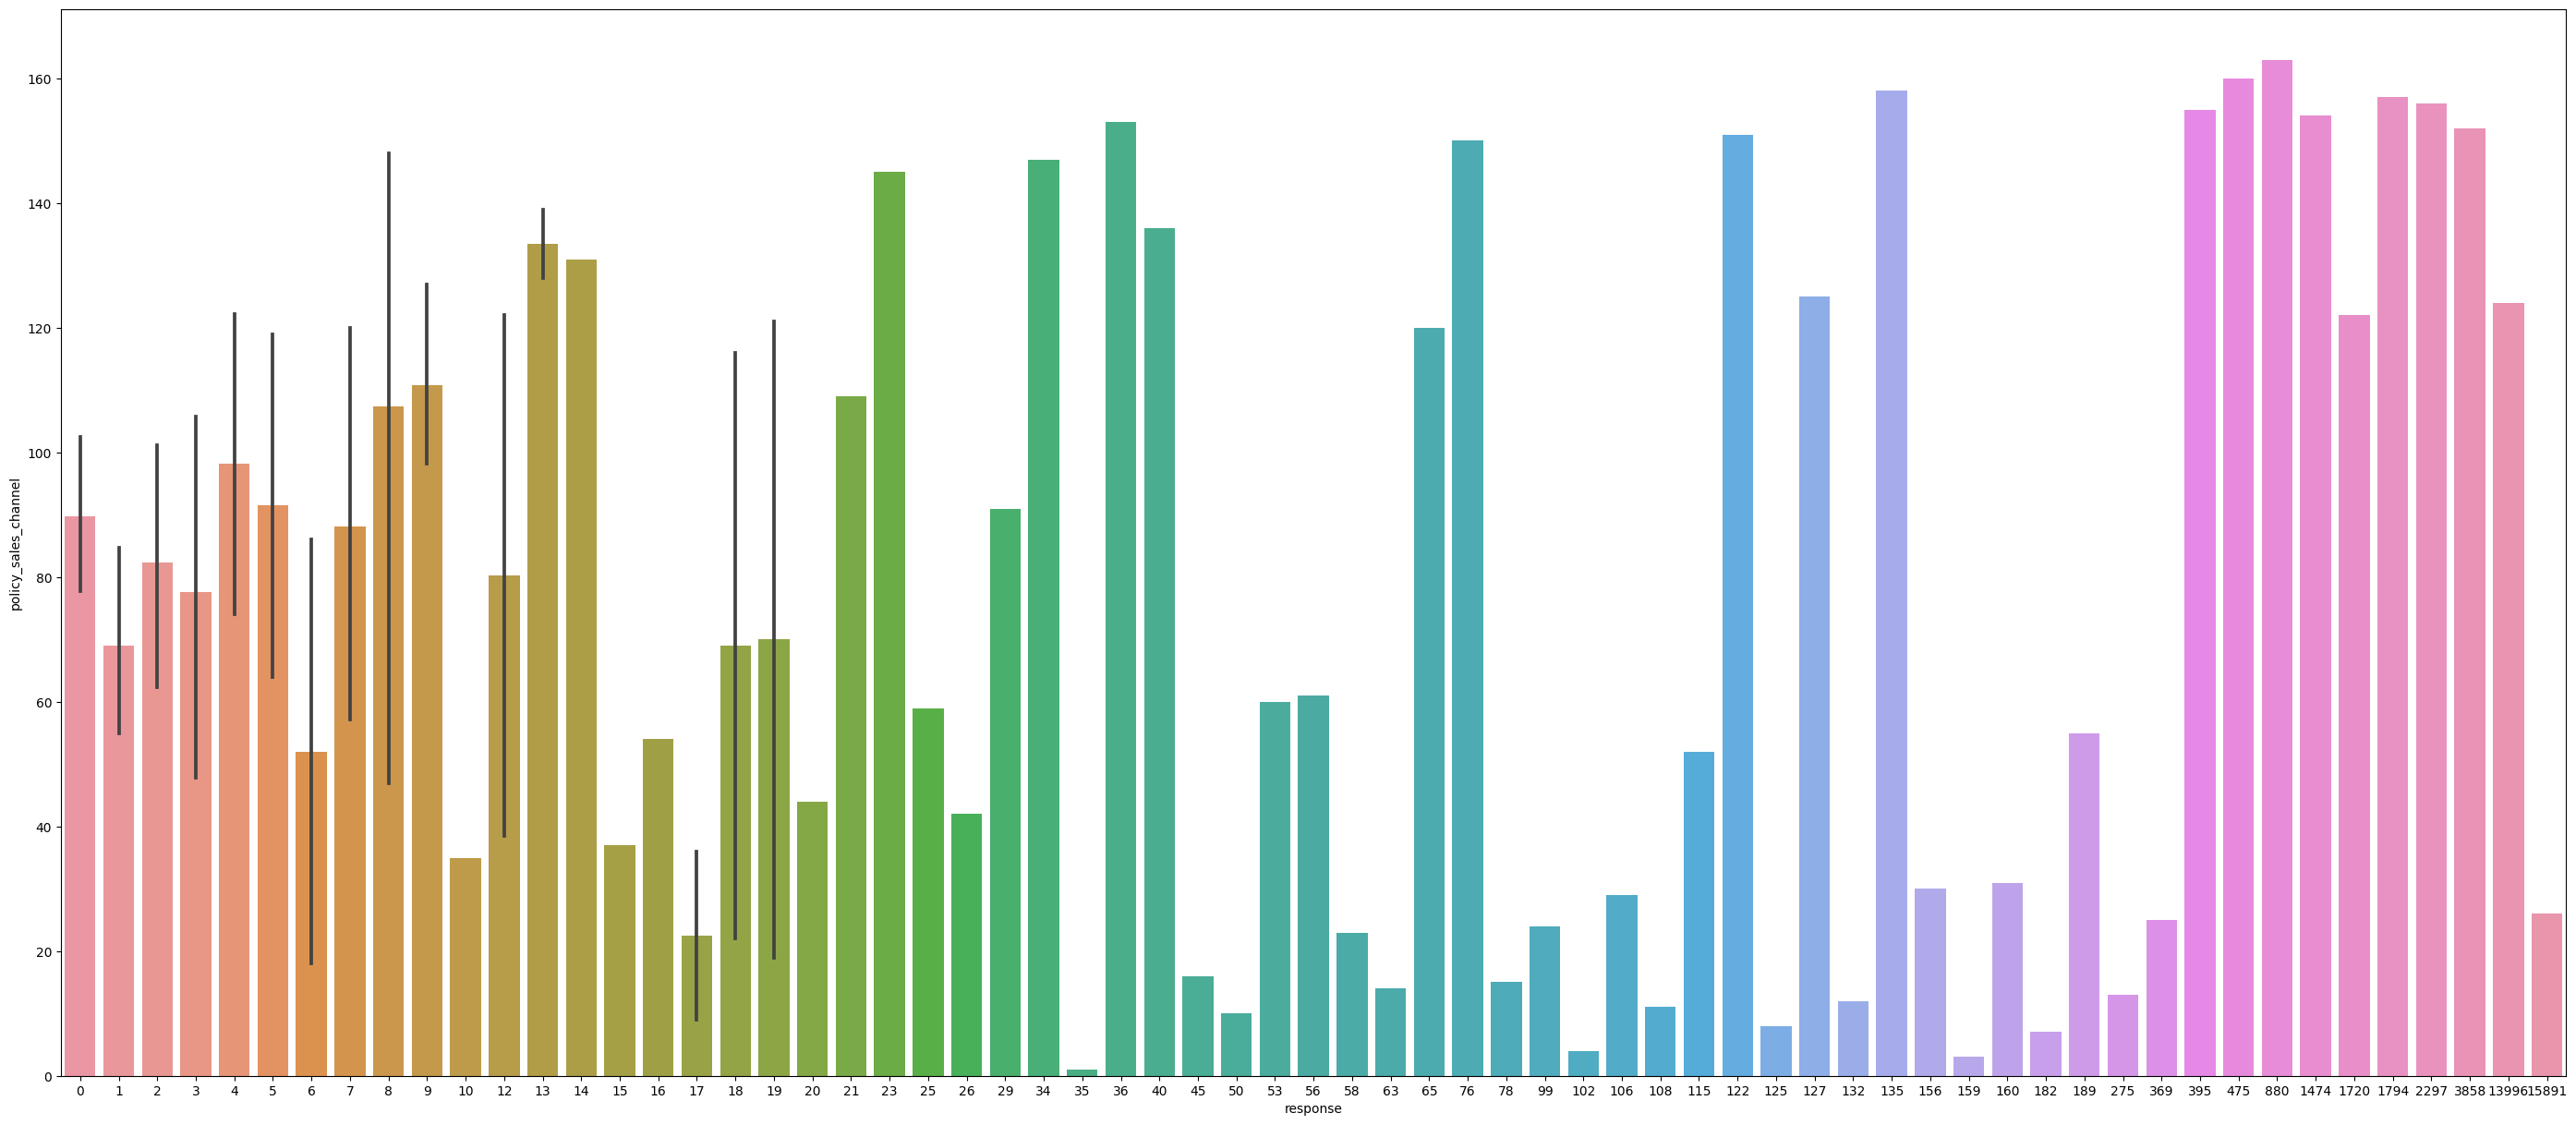

In [24]:
# policy_sales_channel
plt.figure( figsize = (35,15) )
aux = df4[['policy_sales_channel','response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x = 'response', y = 'policy_sales_channel', data = aux )

<Axes: xlabel='response', ylabel='vintage'>

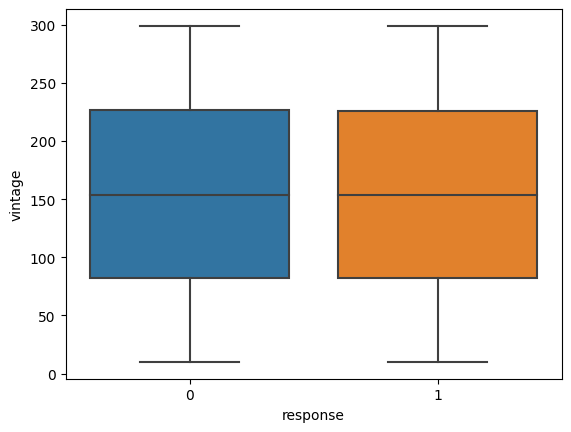

In [25]:
# vintage
sns.boxplot( x = 'response', y = 'vintage', data = df4 )

<Axes: xlabel='vintage', ylabel='Count'>

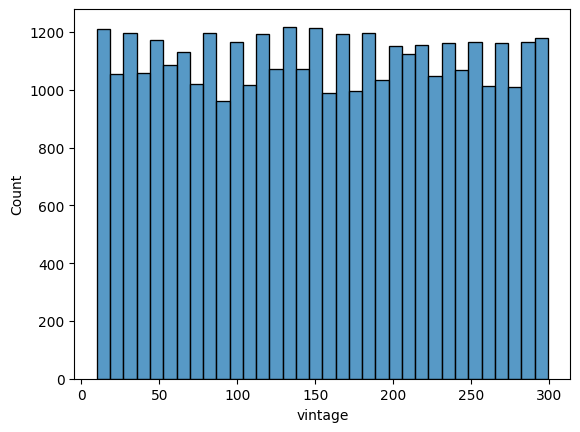

In [26]:
aux00 = df_aux.loc[ df4['response'] == 1 , 'vintage']
sns.histplot( aux00 )

<Axes: xlabel='vintage', ylabel='Count'>

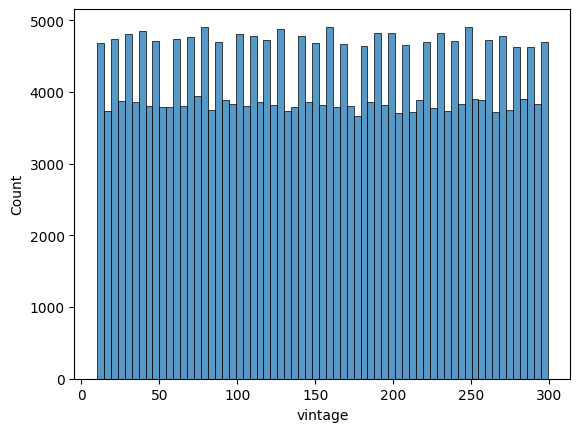

In [27]:
aux00 = df_aux.loc[ df4['response'] == 0 , 'vintage']
sns.histplot( aux00 )

# 5.0 Data Preparation

In [72]:
df5 = df4.copy()

In [73]:
# treino
X = df4.drop( 'response', axis = 1 )
# teste
y = df4['response'].copy()

# separa treino e teste
x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y , test_size = 0.2 )

df5 = pd.concat([ x_train, y_train] , axis = 1  )

## Standardization

In [74]:
# instancia o ss
ss = pp.StandardScaler()
# annual_premium - aplico pois o range é muito amplo
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## Rescaling

In [75]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## Encoder

In [76]:
# gender - One Hot Encoding / Target Encoding
target_encoding_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:,'gender'] = df5['gender'].map( target_encoding_gender )

# region code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_enconding_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:,'region_code'] = df5['region_code'].map( target_enconding_region_code )

# vehicle_age
df5 = pd.get_dummies( data = df5, prefix = 'vehicle_age', columns = ['vehicle_age']  )

# policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

## 5.4 Validation Preparation

In [77]:
# gender
x_validation.loc[: , 'gender'] = x_validation.loc[: , 'gender'].map( target_encoding_gender )

# age
x_validation.loc[: , 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[ : , 'region_code' ] = x_validation.loc[ : , 'region_code' ].map( target_enconding_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'] )

# annual_premium
x_validation.loc[ : , 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[ : , 'policy_sales_channel' ] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[ : , 'vintage' ] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 Feature Selection

## 6.2 Feature Importance

In [79]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators = 250 , random_state = 0 , n_jobs = -1 )

# data preparation
x_train_n = df5.drop(['id','response'], axis = 1)
y_train_n = y_train.values
forest.fit( x_train_n , y_train_n  )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

feature ranking
                         feature  importance
0                        vintage    0.274186
0                 annual_premium    0.245082
0                            age    0.162964
0                    region_code    0.104198
0                 vehicle_damage    0.069181
0           policy_sales_channel    0.060811
0             previously_insured    0.056397
0       vehicle_age_below_1_year    0.013809
0  vehicle_age_between_1_2_years    0.005899
0                         gender    0.004831
0       vehicle_age_over_2_years    0.002145
0                driving_license    0.000497


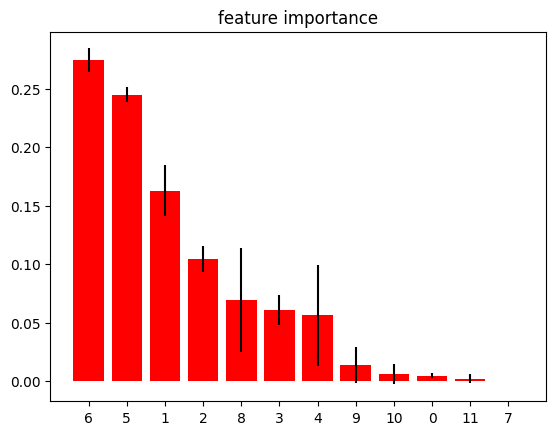

In [80]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis = 0 )
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('feature ranking')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature' : i , 'importance' : j } , index = [0]  )
    df = pd.concat( [df , aux] , axis = 0 )
    
print(df.sort_values('importance', ascending = False) )
      
# Plot the impurity-based feature importance of the forest
plt.figure()
plt.title( 'feature importance' )
plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim( [-1,x_train_n.shape[1]] )
plt.show()



# 7.0 Machine Learning 

In [86]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured']
x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]

## 7.1 Machine Learning 

In [90]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors = 2 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

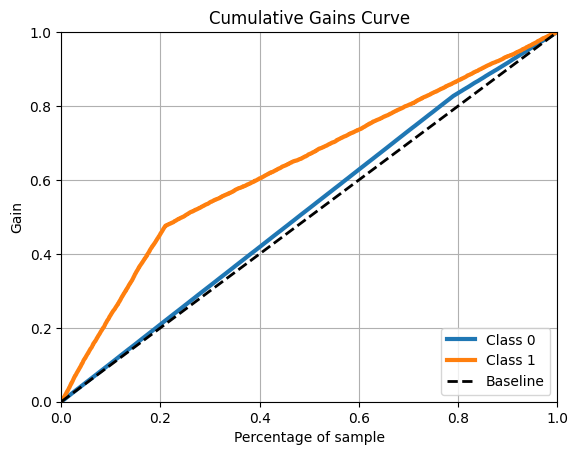

In [91]:
# acumulative gain
skplt.metrics.plot_cumulative_gain( y_validation , yhat_knn )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

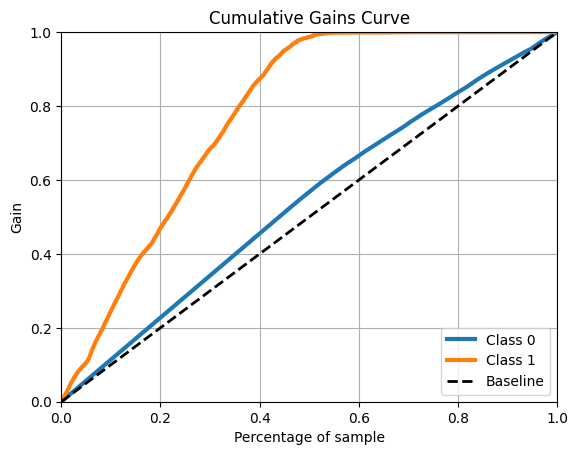

In [92]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# acumulative gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr )

## 8.0 Model Performance 

In [135]:
def precicion_at_k( data , k = 2000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create index
    data['ranking'] = data.index + 1

    # create columns precision score
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[ k, 'precision_at_k' ]


In [136]:
def recall( data , k = 2000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create index
    data['ranking'] = data.index + 1

    # create columns precision score
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[ k, 'recall_at_k' ]


In [137]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sort clients by propensity score
df8.sort_values( 'score', ascending = False )

# precicion_at_k
precision = precicion_at_k( df8, k = 50 )
print( 'Precision at K {}'.format( precision ) )

# recall at k
recall = recall( df8 , k = 50 )
print( 'Recall at k {}'.format( recall ) )

Precision at K 0.1568627450980392
Recall at k 0.0008610483263373157
